TokaMaker Example: Equilibria with toroidally non-continuous conductors in LTX {#doc_tMaker_LTX_ex2}
==========
In this example we show how toroidally non-continuous conductors can be used to model different conditions in LTX-&beta;, including:
 1. Computing eddy currents during the OH pre-charge
 2. Solving for an two sequential "inverse" equilibria, with self-consistent eddy currents between them
 3. Computing vessel and plasma eigenmodes

This example utilizes the mesh built in \ref doc_tMaker_LTX_ex1.

**Warning:** Toroidally non-continuous conducting regions are still in development. Please be careful when using this feature and report any issues.

**Note:** Running this example requires the [h5py](https://www.h5py.org/) python package, which is installable using `pip` or other standard methods.

In [1]:
import os
import sys
import time
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
from scipy.interpolate import CubicSpline
plt.rcParams['figure.figsize']=(6,6)
plt.rcParams['font.weight']='bold'
plt.rcParams['axes.labelweight']='bold'
plt.rcParams['lines.linewidth']=2
plt.rcParams['lines.markeredgewidth']=2
%matplotlib inline
%config InlineBackend.figure_format = "retina"

## Load TokaMaker library

To load the TokaMaker python module we need to tell python where to the module is located. This can be done either through the `PYTHONPATH` environment variable or using within a script using `sys.path.append()` as below, where we look for the environement variable `OFT_ROOTPATH` to provide the path to where the OpenFUSIONToolkit is installed (`/Applications/OFT` on macOS).

For meshing we will use the \ref OpenFUSIONToolkit.TokaMaker.gs_Domain "gs_Domain()" class to build a 2D triangular grid suitable for Grad-Shafranov equilibria. This class uses the [triangle code](https://www.cs.cmu.edu/~quake/triangle.html) through a [python wrapper](https://pypi.org/project/triangle/).

In [2]:
tokamaker_python_path = os.getenv('OFT_ROOTPATH')
if tokamaker_python_path is not None:
    sys.path.append(os.path.join(tokamaker_python_path,'python'))
from OpenFUSIONToolkit.TokaMaker import TokaMaker, load_gs_mesh, create_isoflux

## Setup solver

### Initialize TokaMaker object
First we create a TokaMaker instance to use for equilibrium calculations. Note at present only a single instance can be used per python kernel, so this command should only be called **once** in a given Jupyter notebook or python script. In the future this restriction may be relaxed.

In [3]:
mygs = TokaMaker()

#----------------------------------------------
Open FUSION Toolkit Initialized
Development branch:   tMaker_nonaxi_wall
Revision id:          eeccfcf
Parallelization Info:
  Not compiled with MPI
  # of OpenMP threads =    2
Fortran input file    = oftpyin                                                                         
XML input file        = none                                                                            
Integer Precisions    =    4   8
Float Precisions      =    4   8  16
Complex Precisions    =    4   8
LA backend            = native
#----------------------------------------------



### Load mesh into TokaMaker
Now we load the mesh generated in \ref doc_tMaker_LTX_ex1 using \ref OpenFUSIONToolkit.TokaMaker.load_gs_mesh "load_gs_mesh()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_mesh "setup_mesh()". Then we use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup_regions "setup_regions()" to define the different region types. Finally, we call \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.setup "setup()" to setup the required solver objects. During this call we can specify the desired element order (min=2, max=4) and the toroidal field through F0 = B0*R0, where B0 is the toroidal field at a reference location R0.

We also increase the maximum number of Picard iterations in the equilibrium solve to 80 from the default of 40.

In [4]:
mesh_pts,mesh_lc,mesh_reg,coil_dict,cond_dict = load_gs_mesh('LTX_mesh.h5')
mygs.settings.maxits=80
mygs.setup_mesh(mesh_pts, mesh_lc, mesh_reg)
mygs.setup_regions(cond_dict=cond_dict,coil_dict=coil_dict)
mygs.setup(order=2, F0=0.10752)


**** Generating surface grid level  1
  Generating boundary domain linkage
  Mesh statistics:
    Area         =  2.640E+00
    # of points  =    3125
    # of edges   =    9232
    # of cells   =    6108
    # of boundary points =     140
    # of boundary edges  =     140
    # of boundary cells  =     140
  Resolution statistics:
    hmin =  2.294E-03
    hrms =  3.356E-02
    hmax =  7.597E-02
  Surface grounded at vertex     497


**** Creating Lagrange FE space
  Order  =    2
  Minlev =   -1

 Computing flux BC matrix 
 Inverting real matrix
   Time =    1.8430000000000000E-003


### Define a vertical stability coil
Like many elongated equilibria, the equilibria we seek to compute below are vertically unstable. So we define a pair of coils, and corresponding polarities, that will be used to control the vertical position in the equilibrium solve. In this case we use the "INTERNAL" coils, but in practice this stability is likely provided largely by the shell when plasma are sufficiently elongated.

In [5]:
vsc_signs = np.zeros((mygs.ncoils,), dtype=np.float64)
vsc_signs[[mygs.coil_sets['INTERNALU']['id'], mygs.coil_sets['INTERNALL']['id']]] = [1.0,-1.0]
mygs.set_coil_vsc(vsc_signs)

### Define hard limits on coil currents
Hard limits on coil currents can be set using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_coil_bounds "set_coil_bounds()".

**Note:** The size of the bounds array is `(ncoils+1,2)` as bounds can also be set for the VSC virtual coil, which is treated as a separate degree of freedom if defined.

In [6]:
coil_bounds = np.zeros((mygs.ncoils+1,2), dtype=np.float64)
coil_bounds[:,0] = -1.E98; coil_bounds[:,1] = 1.E98
for name, coil in mygs.coil_sets.items():
    if name.startswith('OH'):
        bounds = [-20.E3, 20.E3]
    elif name.startswith('RED'):
        bounds = [-5.E3, 5.E3]
    elif name.startswith('INTERNAL'):
        bounds = [-10.E3, 10.E3]
    elif name.startswith('GREEN'):
        bounds = [-2.E3, 2.E3]
    elif name.startswith('YELLOW'):
        bounds = [-50.E3, 50.E3]
    elif name.startswith('ORANGE'):
        bounds = [-10.E3, 10.E3]
    elif name.startswith('BLUE'):
        bounds = [-10.E3, 10.E3]
    coil_bounds[coil['id'],:] = np.array(bounds)
coil_bounds[-1,:] = [-5.E3, 5.E3] # VS set
mygs.set_coil_bounds(coil_bounds)

## Compute eddy currents during OH pre-charge

Here we demonstrate how to compute the evolution of vacuum fields in TokaMaker due to specified coil current waveforms and subject to eddy currents in conducting structures. For this example, we are using the "OH precharge", which is typical of most pulsed tokamaks, where the OH transformer is initially ramped to its maximum current (positive or negative) to allow the largest possible swing over the course of the shot ($\Delta I_{OH} \approx 2*I_{OH,max}$). For this example we are ramping to the maximum current over 10 ms.

In [7]:
coil_currents = np.zeros((mygs.ncoils,))
OH_curr_waveform = np.array([
    [0.0,0.0],
    [1.E-2,coil_bounds[mygs.coil_sets['OH']['id'],0]],
    [1.0,coil_bounds[mygs.coil_sets['OH']['id'],0]]
])

### Compute Sequence of Vacuum Equilibria
To view the evolution of the magnetic field and eddy currents during this time we compute a series of vacuum equilibria using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.vac_solve "vac_solve()" from t=0 to t=20 ms. At each time point we set the coil current in the `OH` coil according to the waveform above and use the last state as the reference $\psi$ for \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.set_psi_dt "set_psi_dt()".

In [8]:
psi_last = np.zeros((mygs.np))
t = 0.0
dt = 1.E-3
results = [psi_last]
sim_time = [0.0]
mygs.settings.pm=False
mygs.update_settings()
for i in range(20):
    t += dt
    # Update coil current
    coil_currents[mygs.coil_sets['OH']['id']] = np.interp(t,OH_curr_waveform[:,0],OH_curr_waveform[:,1])
    mygs.set_coil_currents(coil_currents)
    # Solve for new state
    mygs.set_psi_dt(psi_last,dt)
    psi_new, _ = mygs.vac_solve()
    # Save timestep for plotting
    results.append(psi_new)
    sim_time.append(t)
    # Move to previous state
    psi_last = psi_new

### Plot Results
After computing the evolution of the flux we plot the motion of a given as it soaks through the conducting structures and into the bore of the OH. We also plot the eddy currents and $\psi$ at t=10 ms to show an example distribution of eddy currents during the pre-charge.

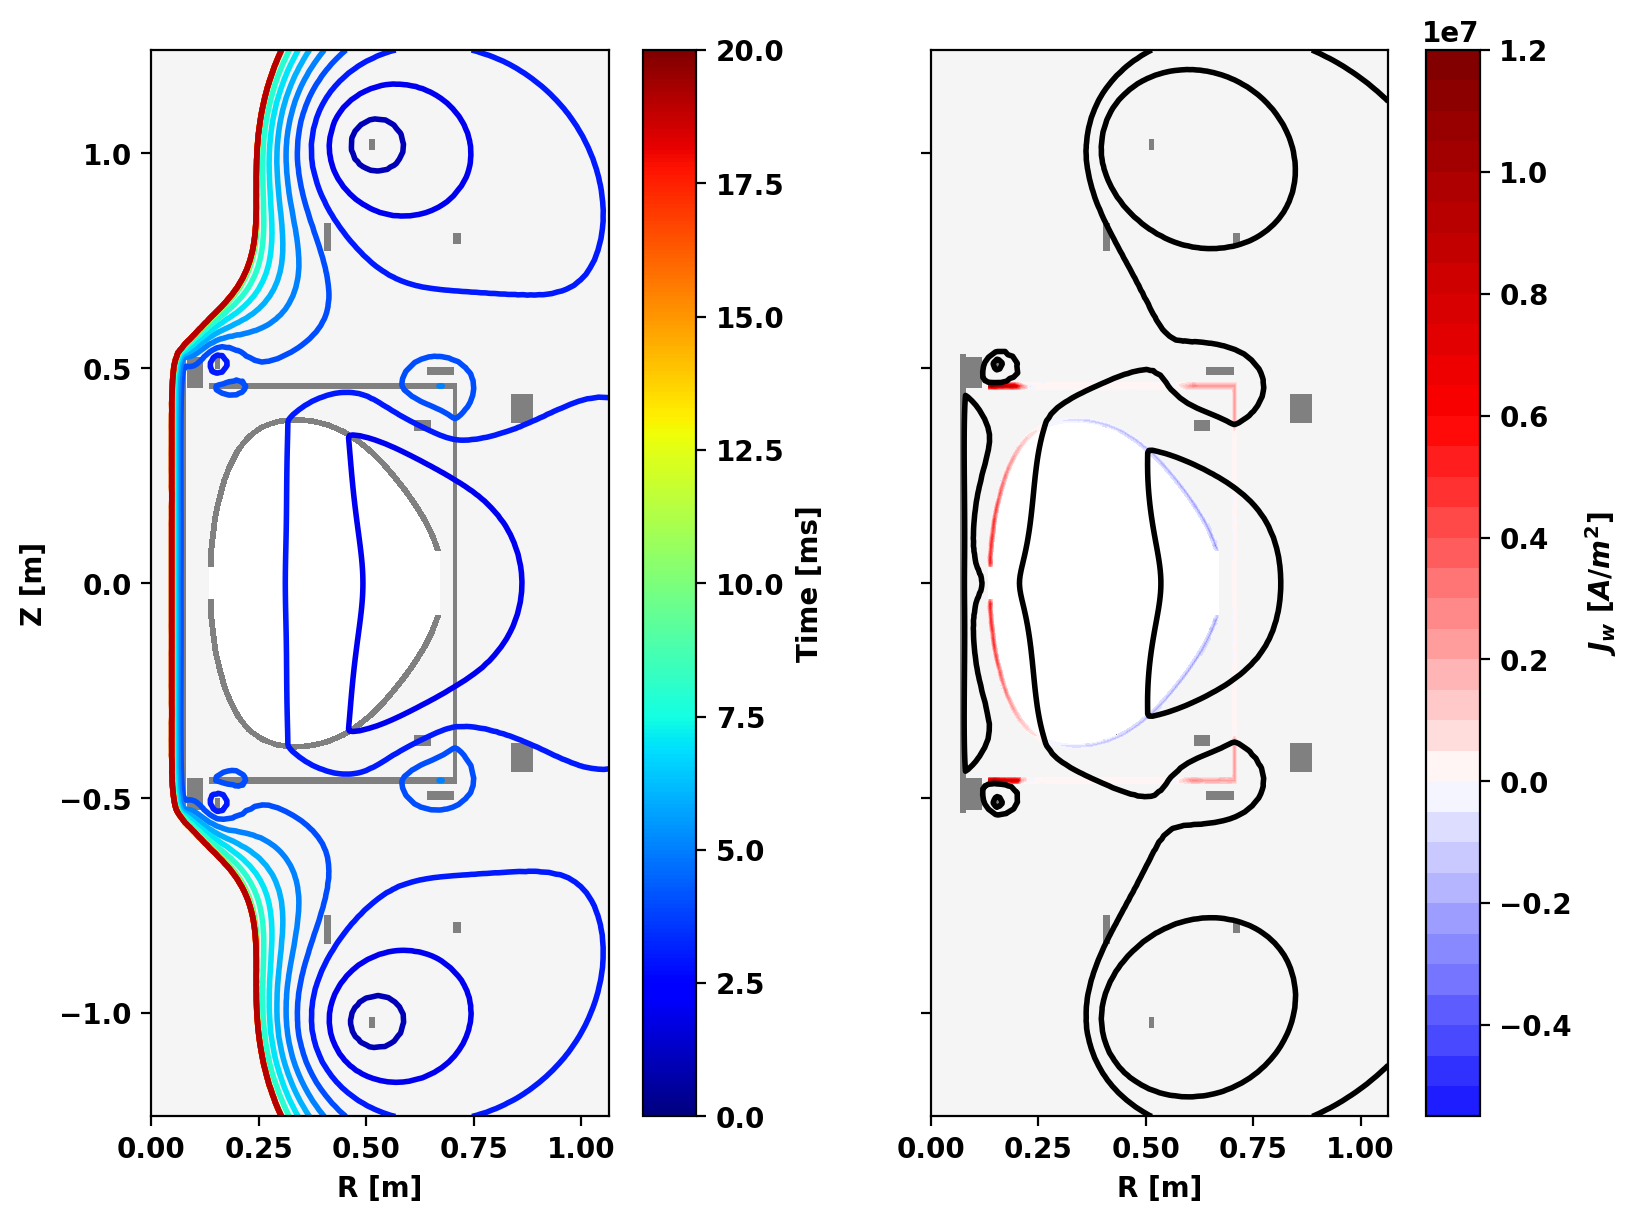

In [9]:
fig, ax = plt.subplots(1,2,sharey=True,figsize=(8,6),constrained_layout=True)
# Plot flux evolution in time
mygs.plot_machine(fig,ax[0],coil_colormap=None,limiter_color=None)
colors = plt.cm.jet(np.linspace(0, 1, len(results)))
for i, result in enumerate(results[1:]):
    mygs.plot_psi(fig,ax[0],psi=-result,normalized=False,plasma_levels=[2.E-3],plasma_color=[colors[i]],vacuum_levels=None,xpoint_color=None)
norm = mpl.colors.Normalize(vmin=0.0, vmax=sim_time[-1]*1.E3)
fig.colorbar(mpl.cm.ScalarMappable(norm=norm, cmap=plt.cm.jet),ax=ax[0],label='Time [ms]')
ax[0].set_ylabel('Z [m]')
ax[0].set_xlabel('R [m]')
# Plot snapshot at t=10 ms
mygs.plot_machine(fig,ax[1],coil_colormap=None,limiter_color=None)
mygs.plot_eddy(fig,ax[1],psi=results[10],colormap='seismic',symmap=True)
mygs.plot_psi(fig,ax[1],psi=-results[10],normalized=False,plasma_levels=[4.7E-3,6.E-3],plasma_color='k',vacuum_levels=None,xpoint_color=None)
_ = ax[-1].set_xlabel('R [m]')

### Compute Decay Modes of Conductor System
Here we compute the decay modes (L/R eigenvalues) of the conductors in our model.

Longest L/R time = 5.1203E-03 [s]


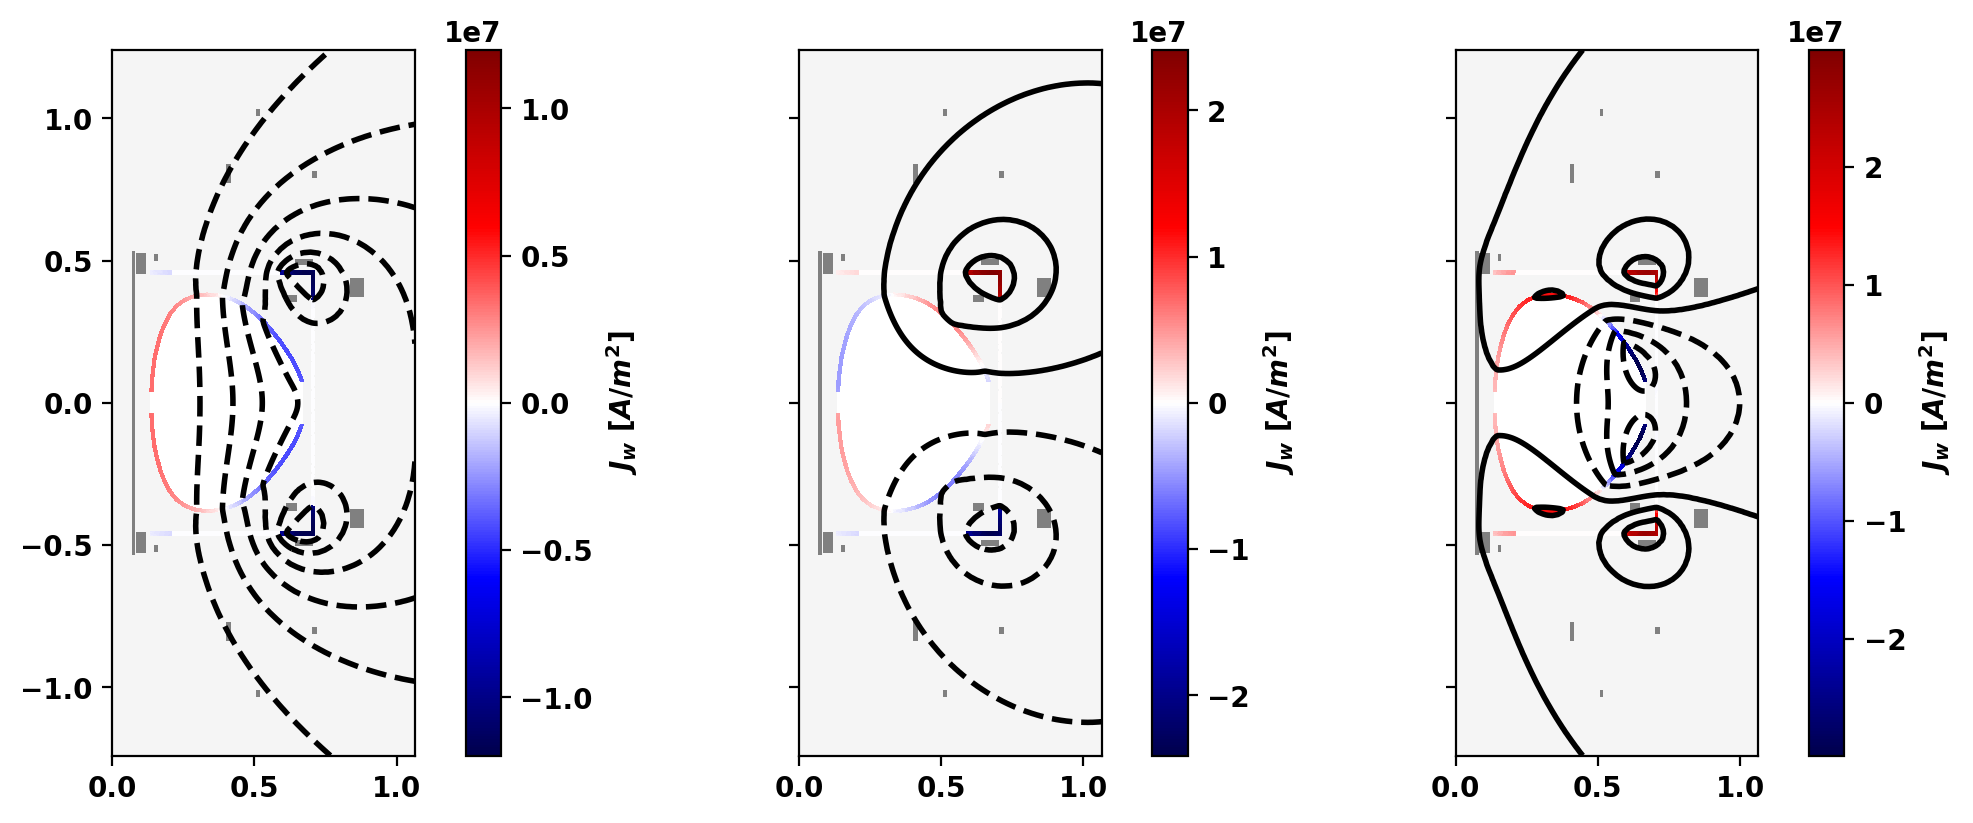

In [10]:
psi0 = mygs.get_psi(False)
eig_vals, eig_vecs = mygs.eig_wall(10)
fig, ax = plt.subplots(1,3,sharey=True,figsize=(10,4),constrained_layout=True)
for i in range(3):
    mygs.plot_machine(fig,ax[i],limiter_color=None)
    mygs.plot_psi(fig,ax[i],eig_vecs[i,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_color='k')
    mygs.plot_eddy(fig,ax[i],dpsi_dt=eig_vecs[i,:]*abs(eig_vals[i,0]),colormap='seismic',symmap=True)
print('Longest L/R time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))

## Compute flattop-like equilibrium

### Define global quantities and targets
For the inverse case we define a target for the plasma current and the ratio the F*F' and P' contributions to the plasma current, which is approximately related to $\beta_p$ as Ip_ratio = $1/\beta_p - 1$.

**Note:** These constraints can be considered "hard" constraints, where they will be matched to good tolerance as long as the calculation converges.

In [11]:
Ip_target = 8.0E4
mygs.set_targets(Ip=Ip_target,Ip_ratio=2.0)

### Define shape targets
In order to constrain the shape of the plasma we can utilize `isoflux` points, which are points we want to lie on the same flux surface (eg. the LCFS).

**Note:** These constraints can be considered "soft" constraints, where the calculation attempts to minimize error in satisfying these constraints subject to other constraints and regularization.

Here we define a somewhat large number of isoflux points that we want to lie on a single surface of the target equilibrium.

In [12]:
isoflux_pts = create_isoflux(20,0.40,0.0,0.22,1.5,0.1)
mygs.set_isoflux(isoflux_pts)

### Define coil regularization matrix
In general, for a given coil set a given plasma shape cannot be exactly reproduced, which generally yields large amplitude coil currents if no constraint on the coil currents is applied. As a result, it is useful to include regularization terms for the coils to balance minimization of the shape error with the amplitude of current in the free coils. In TokaMaker these regularization terms have the general form of a vector of targets (often zero), a regularization matrix that maps the coil currents to the targets, and a vector of weights that can be used to control the relative impact of each term in the minimization.

Here we define two types of regularization targets:
 1. Targets that act to penalize up-down assymetry in U/L coil pairs
 2. Targets the act to penalize the amplitude of current in each coil

In the later case this regularization acts to penalize the amplitude of current in each coil, acting to balance coil current with error in the shape targets. Additionally, this target is also used to "disable" the `YELLOW` coil by setting the weight on its target high to strongly penalize non-zero current.

**Note:** The entry `ncoils+1` corresponds to the VSC virtual coil defined above.

In [13]:
coil_regmat = np.eye(mygs.ncoils+1, dtype=np.float64)
coil_reg_weights = np.zeros((mygs.ncoils+1,), dtype=np.float64)
disable_list = ('YELLOW',)
for name, coil in mygs.coil_sets.items():
    if name[-1] == 'U': # Set regularization to enforce up-down symmetry
        coil_regmat[coil['id'],mygs.coil_sets[name[:-1]+'L']['id']] = -1.0 # Add entry to reference coil (lower partner)
        coil_reg_weights[coil['id']] = 1.E2
    else: # Normal regularization
        if name[:-1] in disable_list:
            coil_reg_weights[coil['id']] = 1.E4
        else:
            coil_reg_weights[coil['id']] = 1.E-1
# Terms for VSC coil
coil_reg_weights[-1] = 1.E-4

mygs.set_coil_reg(coil_regmat,reg_weights=coil_reg_weights)

### Define flux functions
Although TokaMaker has a "default" profile for the F\*F' and P' terms this should almost never be used and one should instead choose an appropriate flux function for their application. In this case we use a simple cubic flux function with the same shape for both F\*F' and P'. Within TokaMaker this profile is represented as a piecewise linear function, which can be set up using the dictionary approach shown below.

*More tools to aide in setting these profiles are coming soon*. For example, Daniel already has a working H-mode pedestal profile with self-consistent bootstrap that we will merge in shortly.

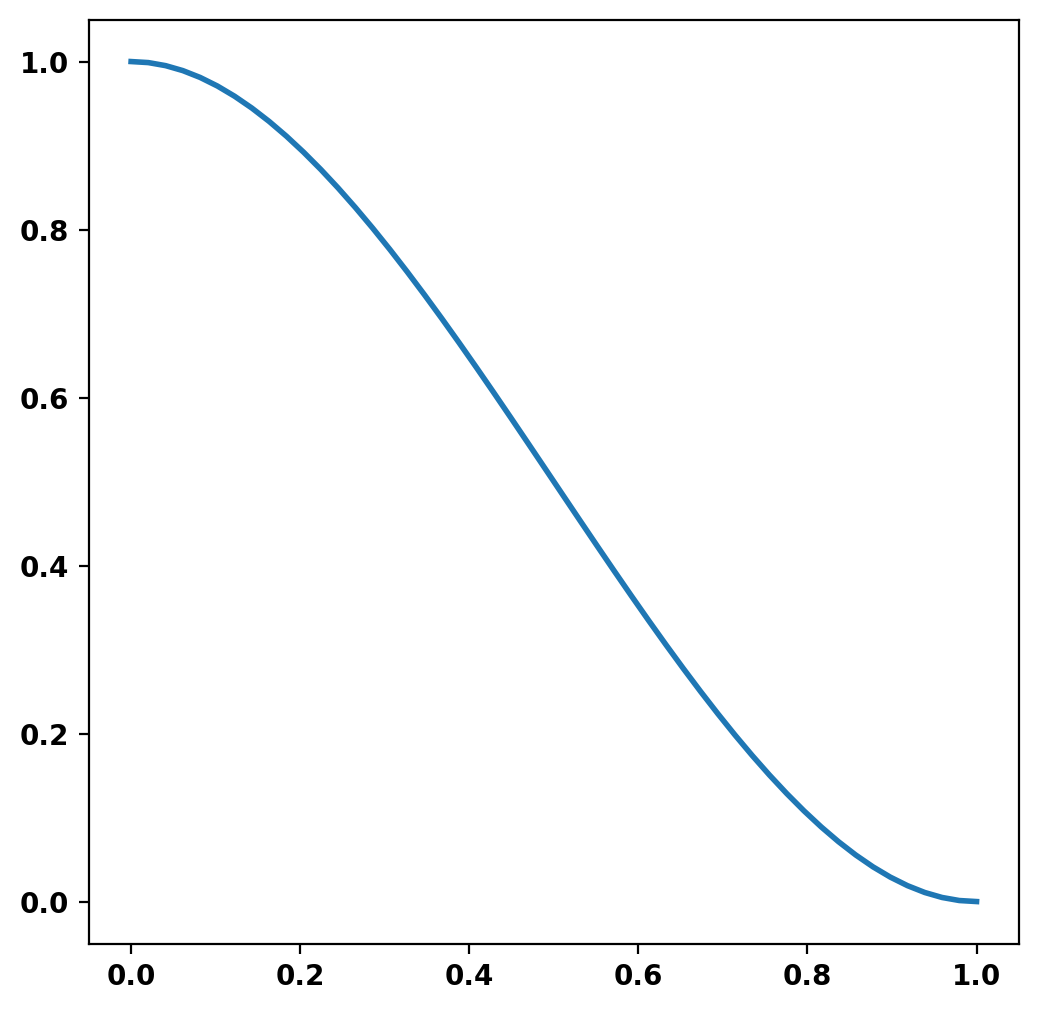

In [14]:
prof = CubicSpline([0.0,0.5,1.0],[1.0,0.5,0.0],bc_type=[[1,0.0],[1,0.0]])
x = np.linspace(0.0,1.0,50)
plt.plot(x,prof(x))
ffp_prof = {
    'type': 'linterp',
    'x': x,
    'y': prof(x)
}
mygs.set_profiles(ffp_prof=ffp_prof,pp_prof=ffp_prof)

### Compute initial equilibrium
We can now compute a free-boundary equilibrium using these constraints. Note that before running a calculation for the first time we must initialize the flux function $\psi$, which can be done using `init_psi`. This subroutine initializes the flux using the specified Ip_target from above, which is evenly distributed over the entire plasma region or only with a boundary defined using a center point (R,Z), minor radius (a), and elongation and triangularity. Coil currents are also initialized at this point using the constraints above and this uniform plasma current initialization. 

We plot the solution and coil currents after initialization but _before_ the Grad-Shafranov solve for reference.

`solve` is then called to compute a self-consitent Grad-Shafranov equilibrium. If the result variable (`err_flag`) is zero then the solution has converged to the desired tolerance ($10^{-6}$ by default).

In [15]:
# Disable eddy currents by removing reference state (dt < 0)
dt=1.0
mygs.set_psi_dt(0.0*mygs.get_psi(False),-dt)
# Initialize solve with a simple current shape
mygs.init_psi(0.42,0.0,0.15,1.5,0.6)
# Re-enable iteration output
mygs.settings.pm=True
mygs.update_settings()
# Compute equilbrium and save flux for later
mygs.solve()
psi_last = mygs.get_psi(False)

Starting non-linear GS solver
     1  4.1859E-01  6.6299E-01  2.7606E-03  4.3538E-01 -6.7576E-05 -4.1309E-01
     2  4.8537E-01  7.5423E-01  1.0738E-03  4.3541E-01 -6.1751E-05 -3.1291E-01
     3  5.1719E-01  7.9712E-01  4.4167E-04  4.3565E-01 -5.6348E-05 -2.8634E-01
     4  5.3386E-01  8.1939E-01  2.0411E-04  4.3587E-01 -5.2437E-05 -2.6167E-01
     5  5.4288E-01  8.3134E-01  1.0265E-04  4.3602E-01 -5.0171E-05 -2.6066E-01
     6  5.4781E-01  8.3784E-01  5.4092E-05  4.3612E-01 -4.8781E-05 -2.6083E-01
     7  5.5053E-01  8.4141E-01  2.9197E-05  4.3619E-01 -4.8001E-05 -2.5823E-01
     8  5.5203E-01  8.4337E-01  1.5961E-05  4.3622E-01 -4.7570E-05 -2.5512E-01
     9  5.5286E-01  8.4445E-01  8.7828E-06  4.3624E-01 -4.7336E-05 -2.5282E-01
    10  5.5332E-01  8.4505E-01  4.8486E-06  4.3626E-01 -4.7215E-05 -2.5123E-01
    11  5.5358E-01  8.4538E-01  2.6817E-06  4.3626E-01 -4.7156E-05 -2.5002E-01
    12  5.5372E-01  8.4557E-01  1.4850E-06  4.3627E-01 -4.7130E-05 -2.4920E-01
    13  5.5380E-01  8.

### Plot equilibrium
Flux surfaces of the computed equilibrium can be plotted using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_psi "plot_psi()" method. The additional plotting methods \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_machine "plot_machine()" and \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_constraints "plot_constraints()" are also used to show context and other information. Each method has a large number of optional arguments for formatting and other options. We also use \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" to show the eddy currents in the vessel due to the change in flux from the preceding equilibrium.

Basic parameters can be displayed using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.print_info "print_info()" method. For access to these quantities as variables instead the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_stats "get_stats()" can be used.

The final coil currents can also be retrieved using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.get_coil_currents "get_coil_currents()" method, which are all within the approximate coil limits imposed above.


Coil Currents [kA]:
  REDU:            0.70 (   5.00) [ 13.94%]
  REDL:            0.70 (   5.00) [ 13.94%]
  ORANGEU:         0.09 (  10.00) [  0.94%]
  ORANGEL:         0.09 (  10.00) [  0.94%]
  YELLOWU:        -0.00 ( -50.00) [  0.00%]
  YELLOWL:        -0.00 ( -50.00) [  0.00%]
  GREENU:          0.43 (   2.00) [ 21.51%]
  GREENL:          0.43 (   2.00) [ 21.51%]
  BLUEU:          -4.22 ( -10.00) [ 42.18%]
  BLUEL:          -4.22 ( -10.00) [ 42.18%]
  INTERNALU:       2.00 (  10.00) [ 19.99%]
  INTERNALL:       2.00 (  10.00) [ 20.00%]
  OH:              0.00 (  20.00) [  0.02%]


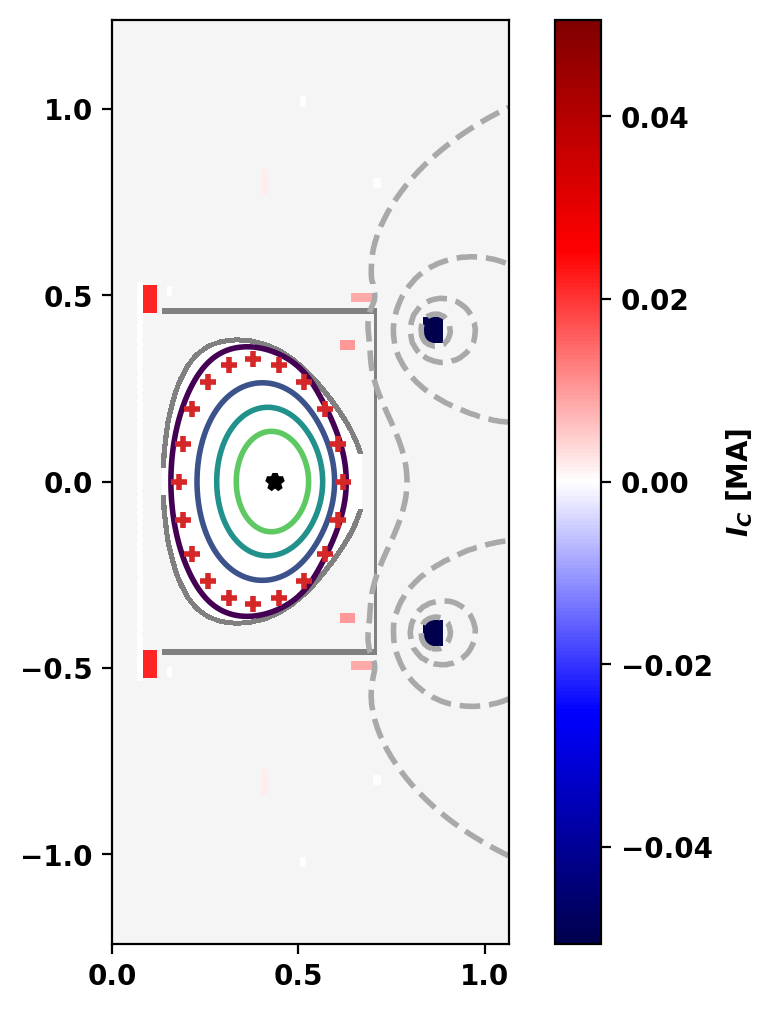

In [16]:
# Plot equilibrium
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,coil_colormap='seismic',coil_scale=1.E-6,coil_clabel=r'$I_C$ [MA]',coil_symmap=True,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_constraints(fig, ax)
# Print information and coil currents
# mygs.print_info()
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    if coil_currents[i] >= 0.0:
        proximity = coil_currents[i]*100/coil_bounds[i,1]
        near_limit = coil_bounds[i,1]
    else:
        proximity = coil_currents[i]*100/coil_bounds[i,0]
        near_limit = coil_bounds[i,0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[i]/1.E3,near_limit/1.E3,proximity))

### Compute equilibrium 5 ms later

In [17]:
# Set prior flux state
mygs.set_psi_dt(psi_last,5.E-3)
# Update Ip target
Ip_target = 9.0E4
mygs.set_targets(Ip=Ip_target,Ip_ratio=2.0)
# Compute new equilbrium and save flux for later
mygs.solve()
psi_new = mygs.get_psi(False)

Starting non-linear GS solver
     1  6.2308E-01  9.5144E-01  4.2011E-04  4.3739E-01 -3.3709E-05 -2.7920E-01
     2  6.3271E-01  9.5602E-01  2.0968E-04  4.3758E-01 -3.1163E-05 -2.8815E-01
     3  6.3267E-01  9.5664E-01  7.5100E-05  4.3736E-01 -3.3550E-05 -2.8915E-01
     4  6.2988E-01  9.5528E-01  3.6073E-05  4.3706E-01 -3.7172E-05 -2.8525E-01
     5  6.2693E-01  9.5339E-01  3.1465E-05  4.3679E-01 -4.0439E-05 -2.7985E-01
     6  6.2467E-01  9.5173E-01  2.5295E-05  4.3661E-01 -4.2771E-05 -2.7449E-01
     7  6.2317E-01  9.5052E-01  1.7684E-05  4.3649E-01 -4.4224E-05 -2.7086E-01
     8  6.2226E-01  9.4973E-01  1.1181E-05  4.3643E-01 -4.5050E-05 -2.6871E-01
     9  6.2176E-01  9.4926E-01  6.5564E-06  4.3639E-01 -4.5481E-05 -2.6764E-01
    10  6.2149E-01  9.4899E-01  3.6174E-06  4.3638E-01 -4.5687E-05 -2.6735E-01
    11  6.2136E-01  9.4884E-01  1.8946E-06  4.3637E-01 -4.5776E-05 -2.6741E-01
    12  6.2129E-01  9.4877E-01  9.4762E-07  4.3637E-01 -4.5809E-05 -2.6759E-01
 Timing:  0.2307119998

### Plot equilibrium
We now show the updated equilibrium, this time using \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" to show the eddy currents in the vessel due to the change in flux from the preceding equilibrium.

Starting CG solver
     0  0.000000E+00  0.000000E+00  2.571336E-02
     1 -2.922025E+00  2.673547E+02  1.000369E-02  3.741731E-05
     2 -3.396356E+00  3.021055E+02  4.393112E-03  1.454165E-05
     3 -3.457512E+00  3.105596E+02  1.631334E-03  5.252887E-06
     4 -3.466481E+00  3.109114E+02  6.493716E-04  2.088607E-06
     5 -3.467961E+00  3.101706E+02  2.387660E-04  7.697891E-07
     6 -3.468161E+00  3.095823E+02  8.790664E-05  2.839524E-07
     7 -3.468193E+00  3.094680E+02  3.702391E-05  1.196373E-07
     8 -3.468197E+00  3.094872E+02  1.637844E-05  5.292121E-08
     9 -3.468198E+00  3.095056E+02  6.451867E-06  2.084572E-08
    10 -3.468198E+00  3.095135E+02  2.275760E-06  7.352701E-09
    20 -3.468198E+00  3.095147E+02  1.742927E-10  5.631160E-13
Equilibrium Statistics:
  Topology                =   Limited
  Toroidal Current [A]    =    9.0004E+04
  Current Centroid [m]    =    0.407  0.000
  Magnetic Axis [m]       =    0.436 -0.000
  Elongation              =    1.530 (U:  1.531

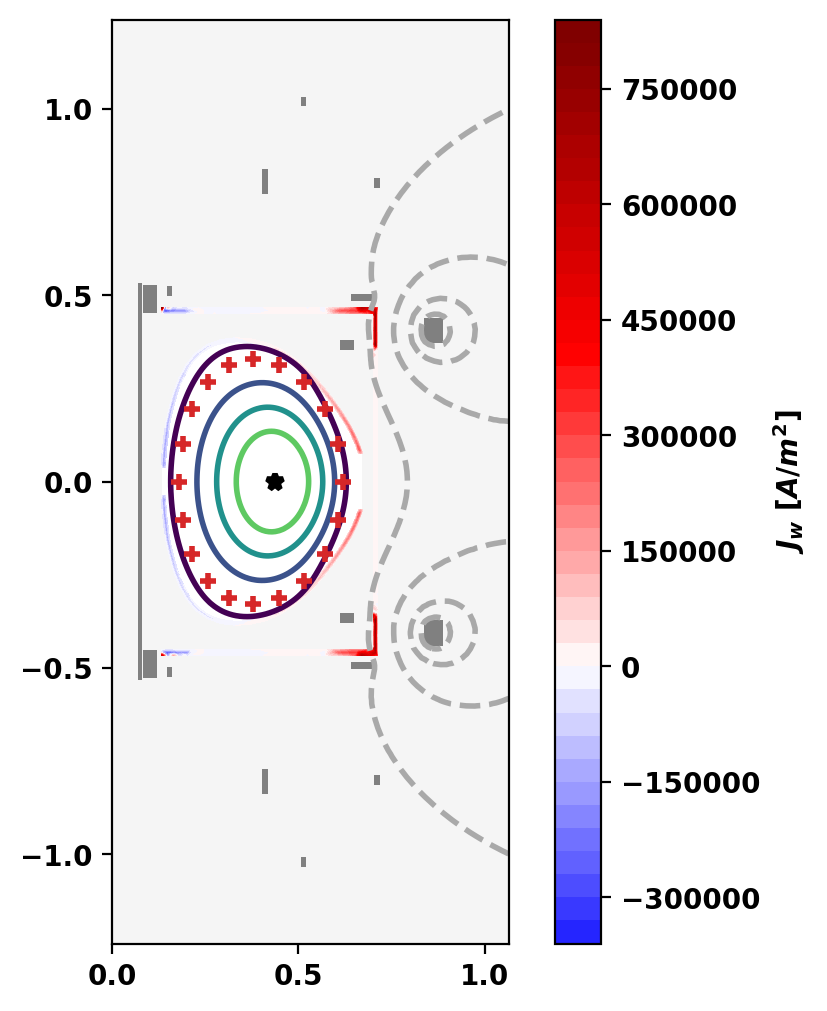

In [18]:
# Plot equilibrium
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,plasma_nlevels=5,vacuum_nlevels=5)
mygs.plot_eddy(fig,ax,psi=psi_new,colormap='seismic',symmap=True)
mygs.plot_constraints(fig, ax)
# Print information and coil currents
mygs.print_info()
print()
print("Coil Currents [kA]:")
coil_currents, _ = mygs.get_coil_currents()
for key in mygs.coil_sets:
    i = mygs.coil_sets[key]['id']
    if coil_currents[i] >= 0.0:
        proximity = coil_currents[i]*100/coil_bounds[i,1]
        near_limit = coil_bounds[i,1]
    else:
        proximity = coil_currents[i]*100/coil_bounds[i,0]
        near_limit = coil_bounds[i,0]
    print('  {0:10} {1:10.2F} ({2:7.2F}) [{3:6.2F}%]'.format(key+":",coil_currents[i]/1.E3,near_limit/1.E3,proximity))

In [19]:
psi_vac, _ = mygs.vac_solve()

Starting vacuum GS solver
     1  5.8357E-01


## Linear Stability Analysis
We can compute the most unstable eigenmodes of the linearized system along with their eigenvalues, or growth rates, using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.eig_td "eig_td()" method.  In this case, the most unstable mode corresponds to vertical instability, and has a growth rate of ~480 s^-1.

We also plot the vertically unstable mode and the eddy currents in conducting structures using the \ref OpenFUSIONToolkit.TokaMaker.TokaMaker.plot_eddy "plot_eddy()" method.

[-480.5524366   222.27954459  299.97542243]
Growth time = -2.0809E-03 [s]


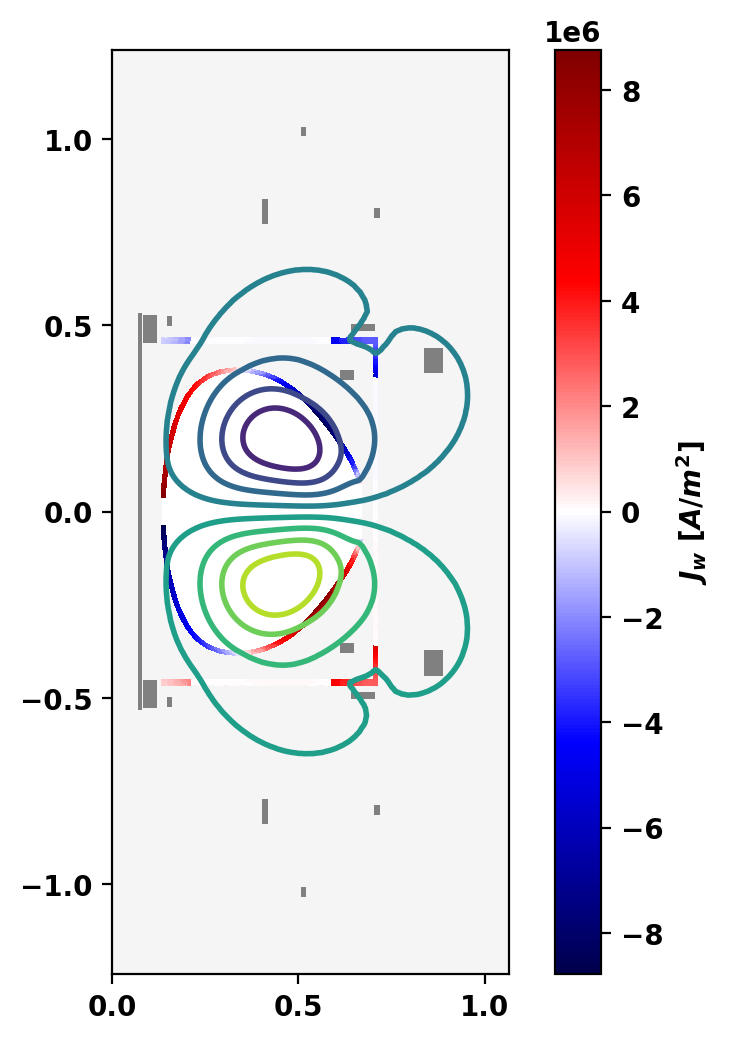

In [20]:
psi0 = mygs.get_psi(False)
eig_vals, eig_vecs = mygs.eig_td(-2.E4,10,False)
fig, ax = plt.subplots(1,1)
mygs.plot_machine(fig,ax,limiter_color=None)
mygs.plot_psi(fig,ax,eig_vecs[0,:],xpoint_color=None,opoint_color=None,normalized=False,plasma_nlevels=10)
mygs.plot_eddy(fig,ax,dpsi_dt=eig_vecs[0,:]*abs(eig_vals[0,0]),colormap='seismic')
print(eig_vals[:3,0])
print('Growth time = {0:.4E} [s]'.format(1.0/eig_vals[0,0]))